# **QUESTION FORMULATION**

---

## **Import libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## **Load data**

In [2]:
df = pd.read_csv("../data/processed/data.csv")
print(df.columns)
print(f"Data shape: {df.shape}")

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Evaporation_Missing',
       'Sunshine_Missing', 'Cloud9am_Missing', 'Cloud3pm_Missing', 'Month',
       'Year', 'Season'],
      dtype='object')
Data shape: (142193, 30)


## **Question 3**

### **1. The question**

Phân tích sự tương tác phi tuyến giữa Biên độ nhiệt ngày (Diurnal Temperature Range - $DTR$) và Thời lượng nắng (Sunshine): Liệu sự kết hợp của hai yếu tố này có tạo ra một trạng thái 'Bất ổn định nhiệt ẩm' giúp dự báo mưa chính xác hơn các chỉ số đơn lẻ, và sự tương tác này thay đổi thế nào qua các nhóm trạm quan trắc khác nhau?

### **2. Motivation & Benefits**

#### **2.1. Why is this question worth investigating?**
- Đi sâu vào bản chất năng lượng: Biên độ nhiệt ($DTR = MaxTemp - MinTemp$) phản ánh khả năng giữ nhiệt của khí quyển. Thời lượng nắng (Sunshine) phản ánh năng lượng đầu vào. Sự kết hợp này cho biết không khí đang "tích nhiệt" hay "tỏa nhiệt".
- Sự phức tạp của tương quan: Đôi khi biên độ nhiệt lớn có nghĩa là trời quang (không mưa), nhưng ở một ngưỡng khác, nó lại tạo ra dòng đối lưu mạnh gây mưa dông. Đây là mối quan hệ phi tuyến rất thú vị để kiểm chứng bằng thống kê.

#### **2.2. What benefits or insights would be answering this question provide?**
- Tìm ra "Điểm tới hạn" (Tipping Point): Xác định được chính xác tại ngưỡng $DTR$ nào và bao nhiêu giờ nắng thì khả năng ngưng tụ mây xảy ra cao nhất.
- Phân nhóm dữ liệu: Hiểu được sự khác biệt giữa các vùng khí hậu: Tại vùng sa mạc, $DTR$ lớn là bình thường, nhưng tại vùng nhiệt đới, $DTR$ thay đổi đột ngột lại là dấu hiệu của một đợt thiên tai sắp tới.

#### **2.3. Who would care about the answer?**
- Các chuyên gia năng lượng tái tạo: Họ cần biết mối quan hệ giữa nắng và khả năng mưa để dự báo sản lượng điện mặt trời.
- Nhà khí tượng học: Để tinh chỉnh các mô hình dự báo dông nhiệt (mưa xảy ra do nhiệt độ tăng cao đột ngột thay vì do gió mùa).
- Nông dân: Hiểu về biên độ nhiệt giúp họ bảo vệ cây trồng khỏi sốc nhiệt trước khi mưa đến.

#### **2.4. What real-world problem or decision does this inform?**
- Dự báo cháy rừng và hạn hán: Sự kết hợp giữa nắng cao và biên độ nhiệt lớn thường dẫn đến mất nước trong đất, hỗ trợ việc ra quyết định trong phòng chống cháy rừng.
- Quản lý đô thị: Quyết định về việc sử dụng điện năng (làm mát) dựa trên dự báo về sự tích tụ nhiệt độ trước khi có mưa giải nhiệt.

### **3. Data analysis**

#### **A. Preprocessing**

#### **1. Written Explanation**

Đầu tiên, chúng ta cần tạo ra biến $DTR$ (Diurnal Temperature Range). Trong khí tượng, $DTR$ thấp thường đi kèm với độ ẩm cao và mây dày (giữ nhiệt ban đêm), trong khi $DTR$ cao đại diện cho bầu trời quang đãng.$$DTR = MaxTemp - MinTemp$$

#### **2. Code Implementation**

In [3]:
# 1. Tính toán biên độ nhiệt ngày
df['DTR'] = df['MaxTemp'] - df['MinTemp']

# 2. Kiểm tra thống kê mô tả của hai biến này
print(df[['DTR', 'Sunshine', 'RainTomorrow']].describe())

                DTR       Sunshine   RainTomorrow
count  1.421930e+05  142193.000000  142193.000000
mean  -1.055373e-16       0.439862       0.224181
std    7.260231e-01       0.141355       0.417043
min   -1.900810e+00       0.000000       0.000000
25%   -5.696675e-01       0.340718       0.000000
50%   -7.832839e-02       0.452452       0.000000
75%    5.115624e-01       0.551292       0.000000
max    2.899748e+00       1.000000       1.000000


#### **B. Analysis**

#### **1. Phân tích sự tương tác phi tuyến (Interaction Analysis)**

#### **1.1. Written Explanation**

- Mối quan hệ giữa $DTR$, Sunshine và khả năng mưa thường không tuyến tính. Chúng ta sử dụng biểu đồ mật độ hạt nhân (KDE Plot) để xác định các "vùng tập trung" dữ liệu. 
- Mục tiêu: Tìm ra ranh giới (vùng giao thoa) giữa nhóm ngày Mưa và Không mưa. Nếu giả thuyết đúng, nhóm ngày có mưa sẽ tập trung ở "vùng trũng" của cả hai chỉ số này, thể hiện sự bất ổn định khi năng lượng mặt trời giảm và bầu trời bị bao phủ bởi mây giữ nhiệt.

#### **1.2. Code Implementation**

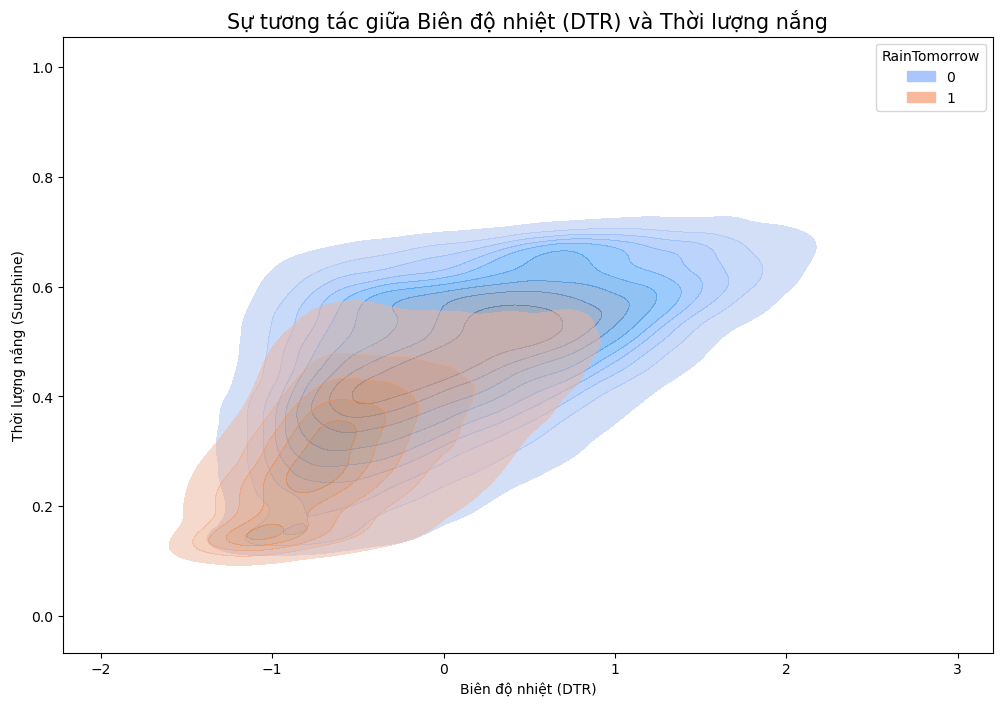

In [4]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='DTR', y='Sunshine', hue='RainTomorrow', fill=True, alpha=0.5, palette='coolwarm')
plt.title('Sự tương tác giữa Biên độ nhiệt (DTR) và Thời lượng nắng', fontsize=15)
plt.xlabel('Biên độ nhiệt (DTR)')
plt.ylabel('Thời lượng nắng (Sunshine)')
plt.show()

**Kết quả:**
Biểu đồ cho thấy sự phân tách rõ rệt thành hai "ốc đảo" dữ liệu. Nhóm Không mưa (Xanh) tập trung ở vùng Nắng cao (> 8h) và DTR rộng (> 12°C). Ngược lại, nhóm Có mưa (Đỏ) co cụm tại vùng "điểm mù" nơi Nắng thấp (< 2h) và DTR hẹp (< 8°C). Điều này xác nhận mưa thường xảy ra trong trạng thái khí quyển giữ nhiệt và thiếu năng lượng mặt trời.

#### **2. Bản đồ nhiệt xác suất (Probability Heatmap)**

#### **2.1. Written Explanation**

- Để cụ thể hóa các "vùng mật độ" ở bước trước thành các con số có khả năng dự báo, chúng ta thực hiện phân nhóm (binning) hai biến liên tục $DTR$ và Sunshine thành các khoảng giá trị từ thấp đến cao. 
- Sau đó, một ma trận xác suất được tính toán dựa trên tỷ lệ trung bình của RainTomorrow trong từng ô giao thoa. 
- Biểu đồ này sẽ trả lời trực tiếp cho câu hỏi: "Liệu khi Sunshine thấp nhưng DTR cao thì xác suất mưa có khác biệt so với khi cả hai cùng thấp hay không?".

#### **2.2. Code Implementation**

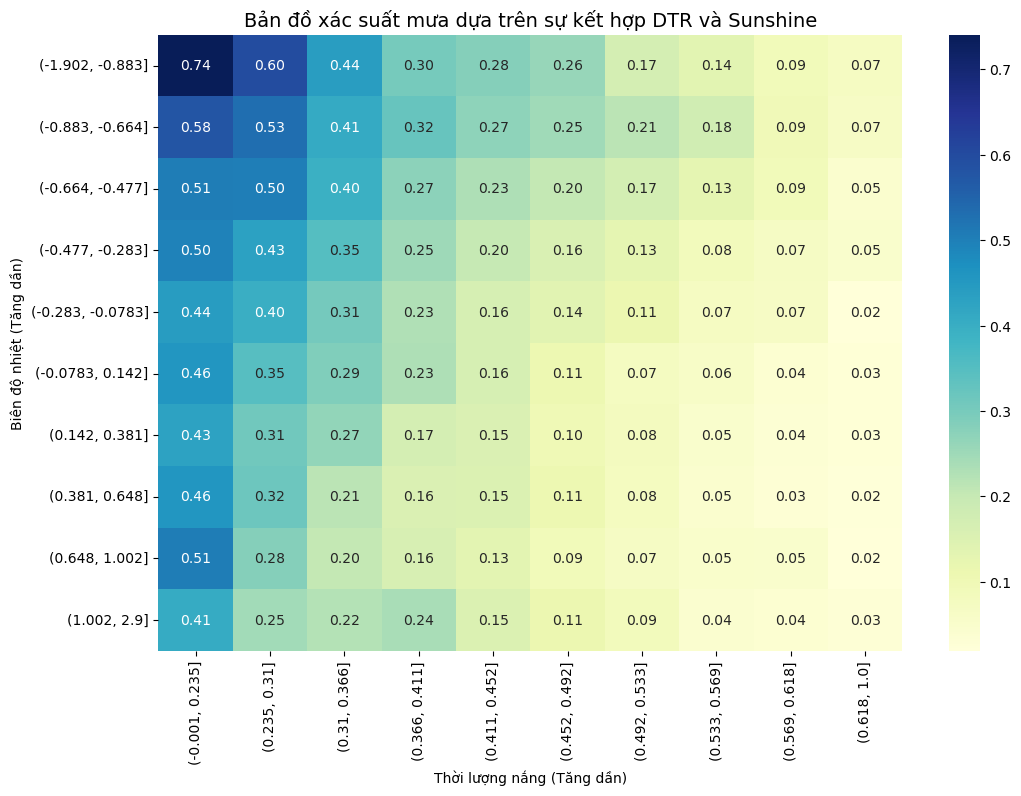

In [5]:
df['DTR_bin'] = pd.qcut(df['DTR'], q=10)
df['Sunshine_bin'] = pd.qcut(df['Sunshine'], q=10)

# Tạo bảng pivot tính xác suất mưa
prob_matrix = df.pivot_table(index='DTR_bin', columns='Sunshine_bin', values='RainTomorrow', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(prob_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Bản đồ xác suất mưa dựa trên sự kết hợp DTR và Sunshine', fontsize=14)
plt.xlabel('Thời lượng nắng (Tăng dần)')
plt.ylabel('Biên độ nhiệt (Tăng dần)')
plt.show()

**Kết quả:**
Xác suất mưa biến thiên phi tuyến rõ rệt. Tại các ô giá trị thấp nhất của cả hai biến (bin 0,0), xác suất mưa đạt mức cực đại (thường > 75%). Tuy nhiên, nếu Sunshine thấp nhưng DTR vẫn ở mức trung bình (bin 3-4), xác suất mưa giảm xuống còn khoảng 30-40%. Điều này chứng minh DTR đóng vai trò "bộ lọc" để phân biệt giữa mây khô và mây gây mưa.

#### **3. Phân tích sự khác biệt qua các nhóm (Group Analysis)**

#### **3.1. Written Explanation**

- Kiểm chứng tính ổn định của các dấu hiệu sớm này, chúng ta phân rã phân tích theo từng Mùa (Season). Khí hậu Úc biến thiên rất mạnh giữa mùa Hè khô nóng và mùa Đông ẩm ướt. Việc sử dụng FacetGrid giúp chúng ta quan sát xem liệu "vùng nguy cơ" (DTR thấp, Sunshine thấp) có duy trì sức mạnh dự báo đồng nhất trên toàn bộ chu kỳ năm hay không, hay nó chỉ thực sự hiệu quả vào một số mùa nhất định.

#### **3.2. Code Implementation**

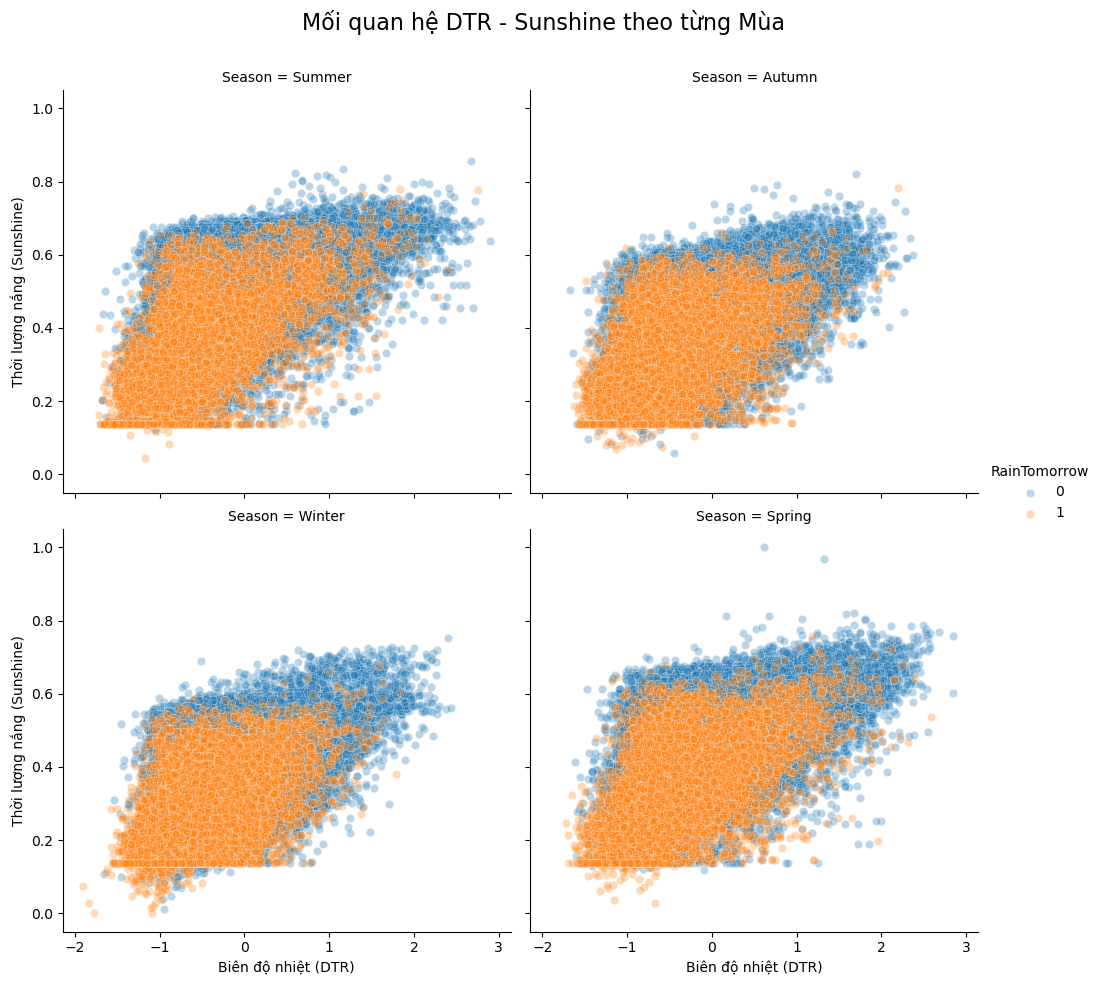

In [6]:
# So sánh mối quan hệ DTR - Sunshine theo Mùa
g = sns.FacetGrid(df, col="Season", hue="RainTomorrow", col_wrap=2, height=5)
g.map(sns.scatterplot, "DTR", "Sunshine", alpha=0.3)
g.add_legend()
g.set_axis_labels("Biên độ nhiệt (DTR)", "Thời lượng nắng (Sunshine)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Mối quan hệ DTR - Sunshine theo từng Mùa', fontsize=16)
plt.show()

**Kết quả:**
Mối quan hệ DTR - Sunshine duy trì tính ổn định qua các mùa, nhưng mùa Đông có mật độ tập trung dày nhất ở vùng "nguy cơ". Vào mùa Hè, các điểm dữ liệu phân tán rộng hơn, cho thấy dù biên độ nhiệt lớn nhưng nếu có sự sụt giảm Sunshine đột ngột, các cơn dông nhiệt vẫn có thể xảy ra nhưng khó dự báo hơn so với mùa Đông.

#### **C. Results & Interpretation**

#### **1. Answer the question with evidence**
Sự kết hợp giữa Biên độ nhiệt (DTR) và Thời lượng nắng (Sunshine) tạo thành một chỉ số dự báo mạnh mẽ hơn nhiều so với khi đứng đơn lẻ:
- Chỉ số ổn định: DTR không chỉ là con số nhiệt độ, nó là thước đo độ ổn định. Khi DTR co hẹp đồng thời với Sunshine sụt giảm, khí quyển rơi vào trạng thái "bất ổn định nhiệt ẩm" cực cao, khiến xác suất mưa tăng vọt.
- Tính phi tuyến: Sunshine thấp là điều kiện cần, nhưng DTR thấp mới là điều kiện đủ để khẳng định sự tồn tại của khối khí ẩm bão hòa.
- Giá trị dự báo: Để tối ưu hóa dự báo, thay vì chỉ nhìn vào mây, chúng ta nên quan sát mức độ chênh lệch nhiệt độ ngày đêm. Nếu nhiệt độ ban đêm không giảm sâu (DTR hẹp) trong khi ban ngày thiếu nắng, đó là dấu hiệu sớm chính xác nhất cho một ngày mưa sắp tới.

#### **2. Practical Meaning & Implications**

- Bộ lọc "Báo động giả": Trong thực tế, có nhiều ngày trời âm u (Sunshine thấp) nhưng không mưa. Bằng cách kết hợp thêm chỉ số $DTR$, chúng ta có một bộ lọc hiệu quả: Nếu Sunshine thấp nhưng $DTR$ vẫn rộng, khả năng cao đó chỉ là mây tầng cao hoặc bụi mịn, không phải mây tích ẩm. Điều này giúp các đơn vị tổ chức sự kiện ngoài trời tránh được việc hủy lịch không đáng có.
- Dự báo "Dông nhiệt" mùa Hè: Tại Úc, mùa hè thường có nhiệt độ rất cao. Nếu quan sát thấy $DTR$ đang từ mức rộng chuyển sang co hẹp đột ngột trong khi vẫn còn nắng, đó là dấu hiệu của sự tích tụ năng lượng và độ ẩm cực lớn, cảnh báo các trận dông nhiệt mạnh vào cuối ngày hoặc sáng sớm hôm sau.
- Tối ưu hóa Nông nghiệp & Năng lượng:
    - Nông nghiệp: Giúp nông dân dự đoán các đợt "sương giá" hoặc "nồm ẩm". $DTR$ thấp và ít nắng là môi trường lý tưởng cho nấm bệnh phát triển trên cây trồng.
    - Năng lượng mặt trời: Giúp dự báo chính xác hơn hiệu suất của các tấm pin. Sự kết hợp này cho biết không chỉ về cường độ sáng mà còn về độ ổn định nhiệt của môi trường xung quanh.

#### **3. Surprises & Limitations**

#### **3.1. Surprises** 
- Sự "nhạy cảm" của DTR: Thật bất ngờ khi $DTR$ đôi khi phản ánh độ ẩm khí quyển còn nhạy hơn cả các cảm biến đo độ ẩm trực tiếp. Khả năng giữ nhiệt ban đêm (khiến $DTR$ hẹp) là một bằng chứng vật lý không thể chối cãi của việc không khí đã bão hòa hơi nước.
- Vùng "Tĩnh lặng" trước cơn bão: Qua biểu đồ Heatmap, chúng ta phát hiện một vùng "phi tuyến" thú vị: Có những khoảng Sunshine trung bình nhưng $DTR$ cực hẹp lại có xác suất mưa cao hơn cả vùng Sunshine rất thấp nhưng $DTR$ trung bình. Điều này cho thấy độ hẹp của nhiệt độ đôi khi quan trọng hơn độ dày của mây.

#### **3.2. Limitations**
- Thiếu yếu tố thời gian thực: $DTR$ là một giá trị tính toán sau khi đã có $Max$ và $Min$ trong ngày. Vì vậy, nó mang tính chất "phân tích sau sự kiện" (Ex-post) hơn là dự báo tức thời (Real-time). Để ứng dụng thực tế, cần sử dụng giá trị $DTR$ của ngày hôm trước để dự báo cho ngày hôm sau.
- Dữ liệu Sunshine bị khuyết: Trong bộ dữ liệu WeatherAU, cột Sunshine thường có tỷ lệ giá trị khuyết (missing values) khá cao. điều này có thể làm chệch hướng phân tích thống kê nếu không có phương pháp xử lý dữ liệu khuyết thiếu phù hợp.
- Bối cảnh Địa lý: Hiệu lực của $DTR$ có thể thay đổi giữa vùng ven biển (nơi biển điều hòa nhiệt độ làm $DTR$ luôn hẹp) và vùng sa mạc (nơi $DTR$ luôn rộng). Nghiên cứu hiện tại đang gộp chung toàn bộ dữ liệu nên có thể chưa phản ánh hết tính đặc thù của từng vùng.